# Experiment description
## Hypothesis: 
The amount of predictability of aggressive behavior occurrence in the city is bigger for three crime Levels and in a bimester.

## Method: 
- Remove outliers
- Use of predictability for different time windows and crime levels.

## Parameters: 
- Time windows: 7, 14, 28, 84
- Crime levels: 3, 5, 10

## Built-in methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import scipy
import math
from math import pi
%matplotlib inline

In [2]:
def set_initial_dataset_day(df_by_date,name_day):
    df_by_date = df_by_date.reset_index()
    df_by_date['day_of_week'] = df_by_date['date'].dt.day_name()
    monday_idx = df_by_date.index[df_by_date['day_of_week'] == name_day].tolist()[0]
    df_by_date = df_by_date[monday_idx:].set_index('date').drop(['day_of_week'],axis=1)
    return df_by_date

In [3]:
# https://plot.ly/python/v3/fft-filters/
def low_pass_filter(signal_values, fc =0.04, b =0.08):
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    s = signal_values
    s = s - np.nanmean(s)
    filtered_signal = np.convolve(s, sinc_func)
    return filtered_signal

In [4]:
# Methods for slicing windows
def im2patches(im,n):
    patches = [];
    for i in range(len(im)-n):
        patch = im[i:(i+n-1)]        
        patch = patch - np.nanmean(patch);
        if(np.linalg.norm(patch)>0):
            patch = patch/np.linalg.norm(patch);
        if i==0:
            patches = patch;
        else:
            patches = np.vstack((patches,patch))
    return patches;


def writeEmbeding(timeSeries,lenWindow,samplePath):
    slicingWindows = im2patches(timeSeries,lenWindow);
    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/slicing/'
    prevStation = str(samplePath);
    with open(workingPath+'slicingWindows'+"_"+str(prevStation)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = slicingWindows.tolist();                        
        pickle.dump(lv, f, protocol=2)

    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/timeSeries/'    
    with open(workingPath+'timeSeries'+"_"+str(prevStation)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = timeSeries.tolist();                        
        pickle.dump(lv, f, protocol=2)


In [5]:
#Methods for predictability
def getBarcode(samplePath,lenWindow):
    barcode = [];

    with open(workingPath+'timeSeries/'+'timeSeries_'+samplePath+'_'+str(lenWindow)+'_'+'.pickle', 'rb') as f:
            timeSeries = pickle.load(f);            
    return (barcode,timeSeries);

def computeBarcodeEntropy(barsLenB0):
    barlen = np.array(barsLenB0);
    barlen = barlen/barlen.sum();
    hbc = 0;
    for i in range(barlen.shape[0]):
        if barlen[i]!=0:
            hbc = hbc-(barlen[i])*np.log(barlen[i]);
    return hbc;


def computeGeneralPredictability(timeSeries,binsData,lenWindow):
    # Colwell, R. K. (1974). Predictability, constancy, and contingency of periodic phenomena. Ecology, 55(5), 1148-1153.
    # Normalize the caudal values
    nLevels = binsData.shape[0]-1;
    matStations = np.array(timeSeries).reshape((np.array(timeSeries).shape[0]//lenWindow,lenWindow))    

    grandMean = np.mean(np.mean(matStations));
    #matStations = matStations / grandMean;
    N = np.zeros((nLevels,lenWindow));
    for i in range(1,matStations.shape[1]): 
        # Computes histograms per columns
        hist, bin_edges = np.histogram(matStations[:,i],bins = binsData);
        N[:,i] = hist;
    X = np.sum(N, axis=0);
    Y = np.sum(N, axis=1);
    Z = np.sum(Y);
    hx = 0;
    hy = 0;
    hxy = 0;
    for j in range(X.shape[0]):
        if X[j]!=0:
            hx = hx-(X[j]/Z)*np.log(X[j]/Z);
            
    for i in range(Y.shape[0]):
        if Y[i]!=0:
            hy = hy-(Y[i]/Z)*np.log(Y[i]/Z);
            
    for i in range(Y.shape[0]):
        for j in range(X.shape[0]):
            if N[i,j]!=0:
                hxy = hxy-((N[i,j]/Z)*np.log(N[i,j]/Z));    
    
    # predictability
    p = 1 - (hxy - hx)/np.log(N.shape[0]);
    # constancy
    c = 1 - hy/np.log(N.shape[0]);
    # Returns constancy and contingency
    return (c,p-c,p);


In [6]:
def preprocess_df(df):
    #Remove outliers
    q_hi = df["total_eventos"].quantile(0.99)
    df = df[(df["total_eventos"] < q_hi)]
        
    #Make sure dataset starts on Monday for the experiment
    df = set_initial_dataset_day(df,'Monday')

    #Make sure dataset include consecutive dates in period
    idx = pd.date_range(min(df.reset_index().date), max(df.reset_index().date))
    df = df.reindex(idx, fill_value=int(df["total_eventos"].mean()))
    
    return df

## Load data

In [7]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/verify_enrich_nuse_29112019.csv'
df_input = pd.read_csv(data_location,delimiter=",")

In [8]:
df_input['date']=pd.to_datetime(df_input['FECHA'])
df_by_date = pd.DataFrame(df_input.groupby('date').size(),columns=["total_eventos"])

In [9]:
#Remove outliers and be sure dataset starts on Monday for the experiment
df_by_date = preprocess_df(df_by_date)
df_by_date

,total_eventos
2017-01-02,699
2017-01-03,693
2017-01-04,725
2017-01-05,659
2017-01-06,674
...,...
2019-01-27,1442
2019-01-28,711
2019-01-29,740
2019-01-30,816


In [10]:
Levels=[3,5,10]
levelCategories = list(map(lambda x: str(x), Levels))

In [11]:
df_days_values = pd.Series(df_by_date['total_eventos']).values

In [12]:
len(df_days_values)

760

In [13]:
timeWindows = [7, 14, 28, 84]
windowsCategories = list(map(lambda x: str(x), timeWindows))

In [14]:
#lT should be a multiple of each time window (mcm timeWindows and calculate the maximum of points on dataset that are multiple of mcm)
lT = 756
df_days_values = df_days_values[0:756]
len(df_days_values)

756

In [15]:
for lenWindow in timeWindows:
    print(len(df_days_values))
    writeEmbeding(df_days_values[0:lT],lenWindow,'aggressiveBehavior_BOGOTA_no_outliers')

756
756
756
756


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


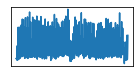

<Figure size 432x288 with 0 Axes>

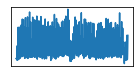

<Figure size 432x288 with 0 Axes>

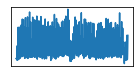

<Figure size 432x288 with 0 Axes>

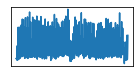

<Figure size 432x288 with 0 Axes>

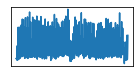

<Figure size 432x288 with 0 Axes>

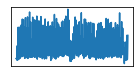

<Figure size 432x288 with 0 Axes>

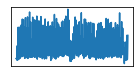

<Figure size 432x288 with 0 Axes>

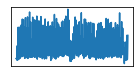

<Figure size 432x288 with 0 Axes>

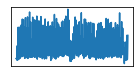

<Figure size 432x288 with 0 Axes>

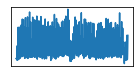

<Figure size 432x288 with 0 Axes>

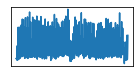

<Figure size 432x288 with 0 Axes>

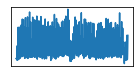

<Figure size 432x288 with 0 Axes>

In [16]:
#find predictability, constancy and contingency
workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/';

flagF = True;
for lenWindow in timeWindows:        
    for nLevels in Levels:
        for expName in ['aggressiveBehavior_BOGOTA_no_outliers']:
            (barcode,timeSeries) = getBarcode(expName,lenWindow);
            binsLevels = np.linspace(np.min(timeSeries),np.max(timeSeries),nLevels);
            
            ## Characterization for B0
            #print('--------------------------')
            #print('Characterization of '+expName)
            plt.figure(figsize=(2.2,1.1))
            plt.plot(timeSeries)
            plt.xticks([])
            plt.yticks([])
            plt.figure()
            
            c,m,p = computeGeneralPredictability(timeSeries,binsLevels,lenWindow)

            if flagF==True:
                flagF = False
                predValues = np.array([expName,lenWindow,nLevels,p,m,c]);
            else:
                predValues = np.vstack((predValues, [expName,lenWindow,nLevels,p,m,c]))    

In [17]:
df_prediction = pd.DataFrame(predValues, columns=['crime_type','lenWindow','crime_level','predictability','contingency','constancy'])

In [18]:
df_agressiveBehavior = df_prediction

In [19]:
join=df_agressiveBehavior.pivot('lenWindow','crime_level','predictability')

In [20]:
var1_order = windowsCategories
var2_order = levelCategories
if len(var2_order) > 0:
    join = join.reindex(var2_order, axis=1)
if len(var1_order) > 0:
    join = join.reindex(var1_order)

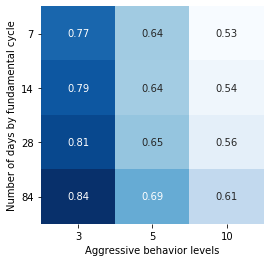

In [22]:
fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
fig.set_size_inches(4, 4)
g=sns.heatmap(join.astype('float'),annot=True,fmt=".2",linewidths=0,cmap="Blues",cbar=False)
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel("Aggressive behavior levels")
ax.set_ylabel("Number of days by fundamental cycle")
file_path = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/figures/'
plt.savefig(file_path+'table_aggressiveBehavior_timeWindows_predictability_no_outliers',dpi=300,bbox_inches = "tight")
plt.show()
